In [1]:
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn import datasets

In [2]:
# Create a dataset, and save to disk
iris = datasets.load_iris()

df_iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

df_iris.to_csv('../data/iris.csv', index=False)

In [3]:
# Load dataset from a csv file
df_iris = pd.read_csv('../data/iris.csv')


[0]	train-merror:0.040107	test-merror:0.0404413
[10]	train-merror:0.023272	test-merror:0.04616
[20]	train-merror:0.019905	test-merror:0.0596407


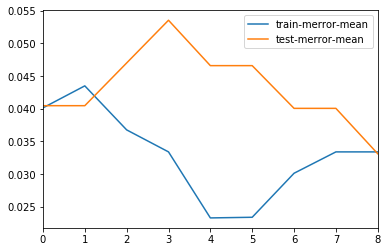

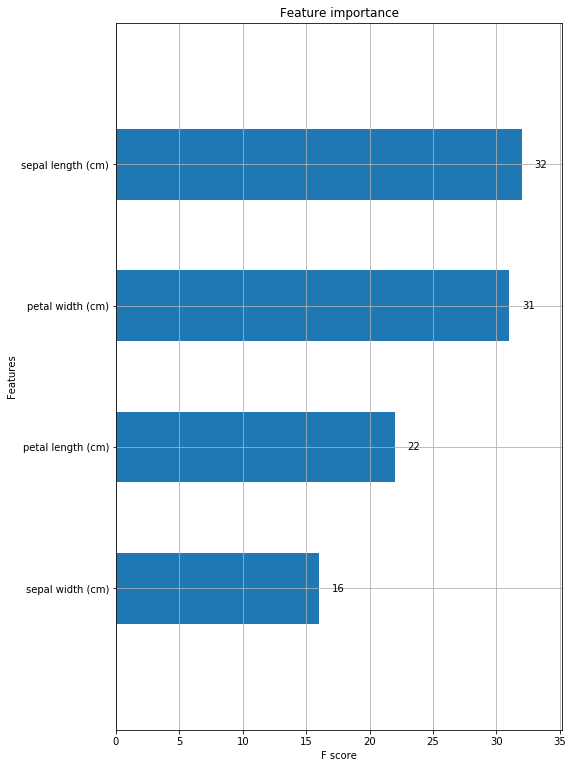

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

# Load dataset from a csv file
df_data = pd.read_csv('../data/iris.csv')

TARGET = 'target'

y_train = df_data[TARGET].astype(int)
x_train = df_data.drop([TARGET], axis=1)

#can't merge train with test because the kernel run for very long time

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
                
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'silent': 1,
    'num_class': 3
}

dtrain = xgb.DMatrix(x_train, label=y_train)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=10, show_stdv=False, folds=5)
cv_output[['train-merror-mean', 'test-merror-mean']].plot()

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [5]:
from sklearn import ensemble

In [6]:
# Using SKLEARN version of the pipeline
model = Pipeline([('imputer', preprocessing.Imputer()),
                 ('scaler', preprocessing.StandardScaler()),
                 ('classifier', ensemble.RandomForestClassifier())
                ])

# model = Pipeline([('scaler', preprocessing.StandardScaler()),
#                   ('classifier', xgb.XGBClassifier(**xgb_params))
#                 ])


from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, x_train, y_train, scoring="accuracy", cv=5)
print('Scores mean', np.mean(scores), 'std', np.std(scores))  
print('Scores', scores)  

import pickle
model.fit(x_train, y_train)
pickle.dump(model, open('../webapp/model.pkl', 'wb'))


Scores mean 0.96 std 0.0249443825785
Scores [ 0.96666667  0.96666667  0.93333333  0.93333333  1.        ]


In [7]:
# Start cut and paste
######################################################
# This gets cut and paste to flask app

import pickle
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
import numpy as np

model = pickle.load( open('../webapp/model.pkl', 'rb') ) # Change path

def _predict(request_dict):
    values = [
        request_dict['sepal_length'],
        request_dict['sepal_width'],
        request_dict['petal_length'],
        request_dict['petal_width']
        ]
    values = [np.nan if value == '' else value for value in values]
    values = [values]
    pred = model.predict_proba(values)[0]
    return pred

######################################################
# End cut and paste

# Test the interface
pred = _predict(
         {"sepal_length":"5.1",
         "sepal_width":"3.5",
         "petal_length":"1.4",
         "petal_width":"0.2"})

print(pred)

[ 1.  0.  0.]
